# setup

In [1]:

import os, sys
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from tqdm import tqdm
 

import scipy as sp
import sys
library_path = "/home/xilinx/jupyter_notebooks/nthu/Library" 
sys.path.extend([library_path,library_path+"/labber_api", library_path+"/qick_lib"])
 
import json
import Labber
import enlighten
from attrdict import AttrDict
  

from qick import *
import time 

# TODO: fill in the path to bitstream files. The bitstream files are in "bitstream files.zip".
bitfile_path = '/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/top216_pfb2-sgMux1.bit'

soc = QickSoc(bitfile = bitfile_path, external_clk = True)
soccfg = soc
print(soccfg)

Populating the interactive namespace from numpy and matplotlib


resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.220
	Firmware timestamp: Tue Aug  1 13:26:58 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 

In [ ]:
#

In [2]:
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)

In [7]:
from sqckit.labber_toolv2 import InstrManager, hdf5_generator
import pprint
a = InstrManager(server_ip='192.168.10.39')
a.add_instrument(sHardware='Yokogawa GS200 DC Source',
                    dComCfg={'name':'globalFlux',
                            'address': '0x0B21::0x0039::90ZB35282',
                            'interface': 'USB'})
state=[True, False]
yoko_cfg = {'Output': state[0],
            'Function': 'Current',
            'Range (I)': '1 mA',
           'Current - Sweep rate':10e-6}
a.ctrl.globalFlux.setInstrConfig(yoko_cfg)
sweep_rate = 10e-6
pprint.pprint(a.config)

Activate globalFlux successfully.
{'instruments': {'globalFlux': {'communication': {'address': '0x0B21::0x0039::90ZB35282',
                                                  'interface': 'USB'},
                                'description': 'You can write some purposes of '
                                               'globalFlux.',
                                'quantity': {'Current': 0.00023,
                                             'Current - Sweep rate': 1e-05,
                                             'Function': 'Current',
                                             'Output': True,
                                             'Range (I)': '1 mA'},
                                'sHardware': 'Yokogawa GS200 DC Source'}},
 'server_ip': '192.168.10.39'}


# current

In [281]:
# a.ctrl.globalFlux.setValue('Current', 650e-6, rate=sweep_rate)
# a.ctrl.globalFlux.setValue('Current', 634e-6, rate=sweep_rate)
# a.ctrl.globalFlux.setValue('Current', 0.33e-3, rate=sweep_rate)
a.ctrl.globalFlux.setValue('Current', 0, rate=sweep_rate)

0.0

In [9]:
from os.path import isdir, join
import os
import requests
from datetime import datetime
from numpy import pi

def hdf5_generator(
        filepath: str,
        x_info:dict, z_info:dict, 
        y_info:dict = None, comment = None, tag = None):
    
    zdata = z_info['values']
    z_info.update({'complex': True, 'vector': False})
    log_channels = [z_info]
    step_channels = list(filter(None, [x_info, y_info]))

    fObj = Labber.createLogFile_ForData(filepath, log_channels, step_channels)
    if y_info:
        for trace in zdata:
            fObj.addEntry({z_info['name']: trace})
    else:
        fObj.addEntry({z_info['name']: zdata})

    if comment: fObj.setComment(comment)
    if tag: fObj.setTags(tag)
    
def upload_file2server(filepath: str, server_ip: str, port: int):
    url = f'http://{server_ip}:{port}/upload'  
    with open(filepath, 'rb') as file:
        files = {'file': (filepath, file)}
        response = requests.post(url, files=files)

    print(response.text)
    
def create_labber_datafolder(dest_path: str):
    if not isdir(dest_path):
        raise ValueError('Invalid directory')
    yy, mm, dd = datetime.today().strftime('%Y-%m-%d').split('-')
    save_path = join(dest_path, f'{yy}/{mm}/Data_{mm}{dd}')
    if not isdir(save_path):
        os.makedirs(save_path)
    return save_path

# TOF cal

  0%|          | 0/100 [00:00<?, ?it/s]

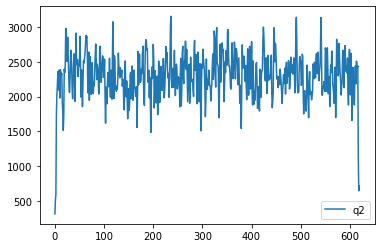

In [54]:
 
     
# q1: 3 , q2: 0, q3: 4.

class TOF(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                 
            self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
 
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    


res_freqs = [5715.4, 6005.5, 5838.5, 5200] # 1, 2, 3, 5.

 
mixer_freq = res_freqs[0]
delta_freq = [freq - mixer_freq for freq in res_freqs]
  
config={ 
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': mixer_freq,
    'delta_freq': delta_freq,     
    
    'gain': [0.5]*4,
    
    "pulse_length": 860,
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": [620]*4,
    'adc_trig_offset':  145,
    
    "relax_delay": 0.0, 
    "soft_avgs": 100,
    "reps": 1   
}

 
prog = TOF(soccfg, config)
 
iq_list = prog.acquire_decimated(soc, progress=True)
 
plt.figure(1)
for ii, iq in enumerate(iq_list):
    if(ii == 2):
        plt.plot(np.abs(iq[0]+1j*iq[1]), label=f'q{ii}') 

plt.legend()
 

In [40]:
soc.us2cycles(2)

860

In [375]:
para = {}

# Onetone

100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


5716.0
6006.0
5829.0


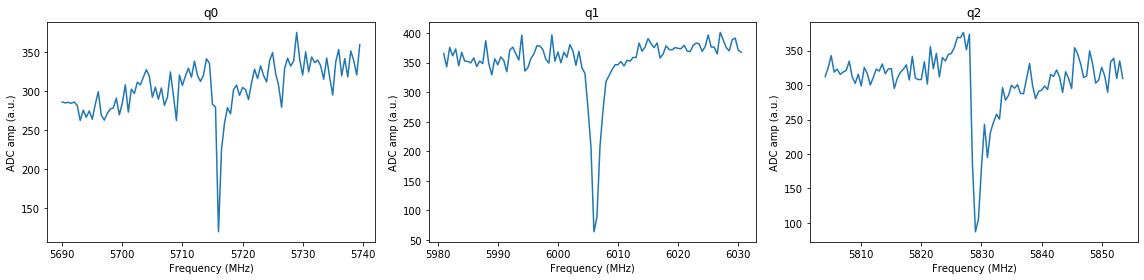

In [643]:


class Onetone(AveragerProgram):
    def initialize(self):
        
        cfg=self.cfg   

        
        self.declare_gen( 
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        


        # will automatically find out mixer freq used by generator (cfg['mixer_freq']) 
            # and add to cfg['freq'][q] inside configure_readout().
        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
        


        self.synci(200)  # give processor some time to configure pulses
    
    
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        self.pulse(ch=self.cfg['sgMux_ch'])
        
        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       

# res_freqs = [5715, 6006, 5829, 5905] # 1, 2, 3, 5.
res_freqs = [5715, 6006, 5829, 5200] # 1, 2, 3, x.
# res_freqs = [5715, 6006, 5895, 5100] # 1, 2, 5, x.
 

mixer_freq = res_freqs[0]
delta_freq = [freq - mixer_freq for freq in res_freqs]

config_onetone={
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': mixer_freq,
    'delta_freq': delta_freq,    
    'gain': [0.067, 0.067, 0.067, 0.067],
#     'gain': [0.037, 0.027, 0.027, 0.027],
    
    "pulse_length": soc.us2cycles(2),
    
    # Order doesn't matter, and length of cfg['mask'] doesn't need to match that of cfg['freq'].
    # If 0 is present, it means cfg['freq'][0] will be part of the output.
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": [620]*4,
    'adc_trig_offset': 145,
    
    "relax_delay": 1.0, 
    "soft_avgs": 1,
    "reps": 100
}




fpts4 = []
span = 50
for fc in res_freqs:
    fpts4.append(np.arange(fc-span//2, fc+span//2, 0.5))

z4 = [[], [], [], []]    
for i in tqdm(range(len(fpts4[0]))):
    
    freqs = [fpts[i] for fpts in fpts4]  
    config_onetone['mixer_freq'] = freqs[0]
    config_onetone['delta_freq'] = [freq - freqs[0] for freq in freqs]
    

    prog = Onetone(soccfg, config_onetone)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4): 
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
 

       
for i in range(4):
    z4[i] = np.array(z4[i]) 
z4 = np.array(z4)    


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(3):
    axs[i].plot(fpts4[i], abs(z4[i]))
    axs[i].set_xlabel('Frequency (MHz)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
plt.tight_layout()    
 
    
for i in range(3):
    idx = np.argmin(abs(z4[i]))
    print(fpts4[i][idx])    

In [641]:
for i in range(3):
    
    hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
    client = Labber.connectToServer(hostip, timeout=86400)
    comment = json.dumps(config_onetone, indent=4) + ',\n all current 0 A.'
    filename = f'muxed_onetone2-q{i}'
    data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
    database_path = create_labber_datafolder(os.path.join(data_path))
    filepath = os.path.join(database_path, filename)
    hdf5_generator(
        filepath = filepath,
        x_info = {'name':'Frequency', 'unit':"Hz", 'values':fpts4[i]*1e6},
        z_info = {'name': 'Signal','unit': 'a.u.','values': z4[i]}, 
        comment = comment, 
        tag = f'OneTone/pdr'
    )
    upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)   
    
    
    
# hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
# client = Labber.connectToServer(hostip, timeout=86400)

# comment = json.dumps(config, indent=4)

# filename = 'muxed_onetone2'
# data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
# database_path = create_labber_datafolder(os.path.join(data_path))
# filepath = os.path.join(database_path, filename)
# hdf5_generator(
#     filepath = filepath,
#     x_info = {'name':'Frequency', 'unit':"Hz", 'values':fpts*1e6},
#     z_info = {'name': 'Signal','unit': 'a.u.','values': z},
#     y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
#     comment = comment, 
#     tag = f'OneTone/pdr'
# )
# upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

2024-06-15 11:35:09,646 - SR_Network:BlockingClient - Error: Connection refused
2024-06-15 11:35:09,829 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_onetone2-q0.hdf5 uploaded successfully
/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_onetone2-q1.hdf5 uploaded successfully


2024-06-15 11:35:10,013 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_onetone2-q2.hdf5 uploaded successfully


# Twotone

100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


[3901.5, 4302.0, 3313.0]

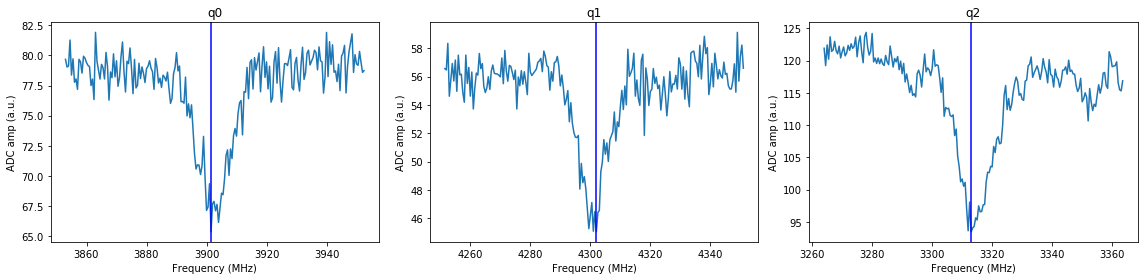

In [648]:
 
     
# q1: 3 , q2: 0, q3: 4.

class Twotone(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_freqs'])):
            
            self.declare_gen(ch=cfg["qubit_chs"][i], nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=cfg["qubit_chs"][i], ro_ch=0) 
            
#             self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="const", freq=freq, 
#                         phase=0, gain=cfg["qubit_gains"][i], length=cfg["qubit_pulse_lengths"][i])
 
        
            self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="flat_top", freq=freq, phase=0, 
                gain=cfg["qubit_gains"][i], waveform=f"qubit{i}", length=cfg["qubit_pulse_lengths"][i])
    
    
            self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_freqs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
        
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
     
# 5716.0
# 6006.0
# 5829.0  

res_freqs = [5715.8, 6005.8, 5828.2, 5200] # 1, 2, 3, 5.
mixer_freq = res_freqs[0]
delta_freq = [freq - mixer_freq for freq in res_freqs]
  

qubit_freqs = [3903.0, 4301.5, 3314.0]


config_twotone={
    'qubit_chs': [3, 0, 4],
    'qubit_freqs': qubit_freqs,  
    'qubit_gains': [4000, 4000, 8000],
    'qubit_sigmas': [2]*3,
    'qubit_pulse_lengths': [600, 600, 600],
    
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': mixer_freq,
    'delta_freq': delta_freq,    

    'gain': [0.027, 0.027, 0.027, 0.067],
    
    "pulse_length": 860,
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": [620]*4,
    'adc_trig_offset':  145, 
    
    "relax_delay": 0.0, 
    "soft_avgs": 20,
    "reps": 1000   
}

fpts4 = []
span = 100
for fc in qubit_freqs:
    fpts4.append(np.arange(fc-span//2, fc+span//2, 0.5))

z4 = [[], [], [], []]    
for i in tqdm(range(len(fpts4[0]))):
     
    config_twotone['qubit_freqs'] = [fpts[i] for fpts in fpts4]   

    prog = Twotone(soccfg, config_twotone)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
    
for i in range(4):
    z4[i] = np.array(z4[i])
    
z4 = np.array(z4)   



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
    amp = abs(z4[i])
    
    axs[i].plot(fpts4[i], amp)
    axs[i].set_xlabel('Frequency (MHz)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')  
    
plt.tight_layout()    
 
    
for i in range(3):
    idx = np.argmin(abs(z4[i]))
    config_twotone['qubit_freqs'][i] = float(fpts4[i][idx])
    axs[i].axvline(x = float(fpts4[i][idx]), color = 'b', label = 'axvline - full height')
config_twotone['qubit_freqs']    

In [555]:
 
for i in range(3):
    idx = np.argmin(abs(z4[i]))
    config_twotone['qubit_freqs'][i] = float(fpts4[i][idx])
config_twotone['qubit_freqs']


[3903.5, 4302.5, 3313.5]

In [649]:
 
    
for i in range(3):
    hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
    client = Labber.connectToServer(hostip, timeout=86400)
    comment = json.dumps(config_twotone, indent=4) + ',\n all current 0 A.'
    filename = f'muxed_twotone2-q{i}'
    data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
    database_path = create_labber_datafolder(os.path.join(data_path))
    filepath = os.path.join(database_path, filename)
    hdf5_generator(
        filepath = filepath,
        x_info = {'name':'Frequency', 'unit':"Hz", 'values':fpts4[i]*1e6},
        z_info = {'name': 'Signal','unit': 'a.u.','values': z4[i]}, 
        comment = comment, 
        tag = f'OneTone/pdr'
    )
    upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)   
    
# hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
# client = Labber.connectToServer(hostip, timeout=86400)
# comment = json.dumps(config, indent=4)
# filename = 'muxed_twotone2'
# data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
# database_path = create_labber_datafolder(os.path.join(data_path))
# filepath = os.path.join(database_path, filename)
# hdf5_generator(
#     filepath = filepath,
#     x_info = {'name':'Frequency', 'unit':"Hz", 'values':fpts*1e6},
#     z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
#     y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
#     comment = comment, 
#     tag = f'OneTone/pdr'
# )
# upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

2024-06-15 11:42:10,137 - SR_Network:BlockingClient - Error: Connection refused
2024-06-15 11:42:10,314 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_twotone2-q0.hdf5 uploaded successfully
/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_twotone2-q1.hdf5 uploaded successfully


2024-06-15 11:42:10,494 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_twotone2-q2.hdf5 uploaded successfully


# Length Rabi

100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


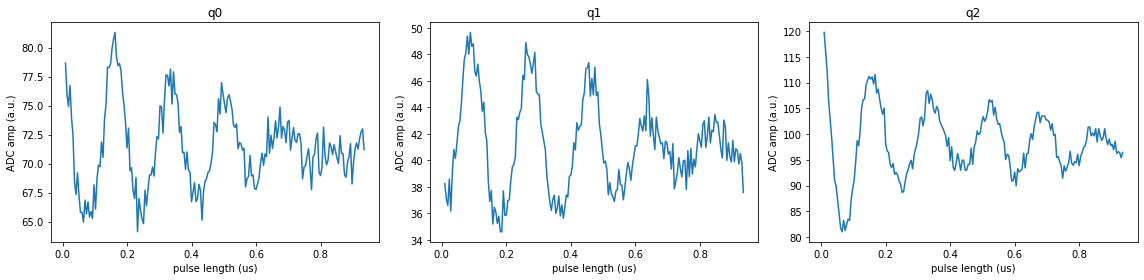

In [650]:

class LenghtRabi(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_chs'])):
            
            self.declare_gen(ch=cfg["qubit_chs"][i], nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=cfg["qubit_chs"][i], ro_ch=0)  
            
#             self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="const", freq=freq, 
#                         phase=0, gain=cfg["qubit_gains"][i], length=cfg["qubit_pulse_length"]) 
            
  
            self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="flat_top", freq=freq, phase=0, 
            gain=cfg["qubit_gains"][i], waveform=f"qubit{i}", length=cfg["qubit_pulse_length"])
    
    
        self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_chs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
            
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
     
# mixer_freq = res_freqs[0]
# delta_freq = [freq - mixer_freq for freq in res_freqs]

config_lenRabi = {
    'qubit_chs': [3, 0, 4],
    'qubit_freqs': config_twotone['qubit_freqs'],   
    'qubit_gains': [4000, 6000, 8000], 
    'qubit_sigmas': [2, 2, 2],
        
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': config_twotone['mixer_freq'],
    'delta_freq': config_twotone['delta_freq'],    
  
    'gain': [0.027, 0.027, 0.027, 0.067],
    
    "pulse_length": config_twotone['pulse_length'],
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths":  config_twotone['readout_lengths'],
    'adc_trig_offset': config_twotone['adc_trig_offset'],
    
    "relax_delay": 10.0, 
    "soft_avgs": 20,
    "reps": 1000   
}


lpts = np.arange(4, 404, 2)
z4 = [[], [], [], []]    

for l in tqdm(lpts):
     
    config_lenRabi['qubit_pulse_length'] = l

    prog = LenghtRabi(soccfg, config_lenRabi)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
 
    axs[i].plot(soc.cycles2us(lpts), abs(z4[i]))
    axs[i].set_xlabel('pulse length (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
     
plt.tight_layout() 



([32, 78, 32], [13, 58, 13])

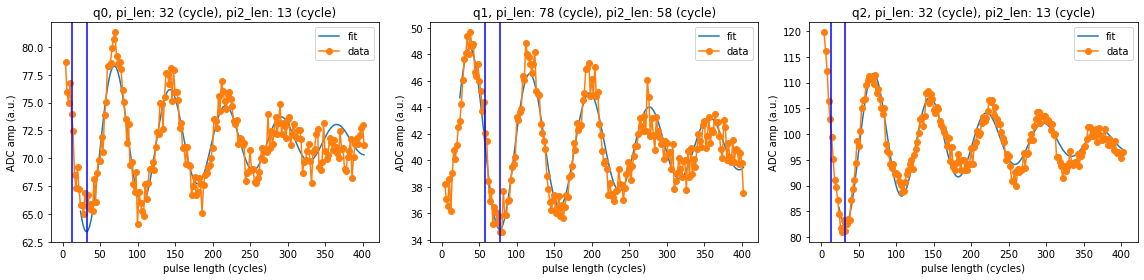

In [657]:

def fit_length_rabi(ch, ax, lpts, amps):
    
#     from fitfun import decaysin, fitdecaysin
  
    def decaysin(x, *p):
        yscale, freq, phase_deg, decay, y0 = p
        return yscale * np.sin(2*np.pi*freq*x + phase_deg*np.pi/180) * np.exp(-x/decay) + y0

    def fitdecaysin(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*5
        else: fitparams = np.copy(fitparams)
        fourier = np.fft.fft(ydata)
        fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
        fft_phases = np.angle(fourier)
        sorted_fourier = np.sort(fourier)
        max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
        if max_ind == 0:
            max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
        max_freq = np.abs(fft_freqs[max_ind])
        max_phase = fft_phases[max_ind]
        if fitparams[0] is None: fitparams[0]=(max(ydata)-min(ydata))/2
        if fitparams[1] is None: fitparams[1]=max_freq
        # if fitparams[2] is None: fitparams[2]=0
        if fitparams[2] is None: fitparams[2]=max_phase*180/np.pi
        if fitparams[3] is None: fitparams[3]=max(xdata) - min(xdata)
        if fitparams[4] is None: fitparams[4]=np.mean(ydata)
        bounds = (
            [0.75*fitparams[0], 0.1/(max(xdata)-min(xdata)), -360, 0.3*(max(xdata)-min(xdata)), np.min(ydata)],
            [1.25*fitparams[0], 30/(max(xdata)-min(xdata)), 360, np.inf, np.max(ydata)]
            )
        for i, param in enumerate(fitparams):
            if not (bounds[0][i] < param < bounds[1][i]):
                fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
                print(f'Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}')
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
#             pOpt, pCov = sp.optimize.curve_fit(decaysin, xdata, ydata, p0=fitparams, bounds=bounds)
            pOpt, pCov = sp.optimize.curve_fit(decaysin, xdata, ydata, p0=fitparams)
            
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov
    
    def sinfunc(x, *p):
        yscale, freq, phase_deg, y0 = p
        return yscale*np.sin(2*np.pi*freq*x + phase_deg*np.pi/180) + y0

    def fitsin(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*4
        else: fitparams = np.copy(fitparams)
        fourier = np.fft.fft(ydata)
        fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
        fft_phases = np.angle(fourier)
        max_ind = np.argmax(np.abs(fourier[1:])) + 1
        max_freq = np.abs(fft_freqs[max_ind])
        max_phase = fft_phases[max_ind]
        if fitparams[0] is None: fitparams[0]=max(ydata)-min(ydata)
        if fitparams[1] is None: fitparams[1]=max_freq
        if fitparams[2] is None: fitparams[2]=max_phase*180/np.pi
        if fitparams[3] is None: fitparams[3]=np.mean(ydata)
        bounds = (
            [0.5*fitparams[0], 0.2/(max(xdata)-min(xdata)), -360, np.min(ydata)],
            [2*fitparams[0], 5/(max(xdata)-min(xdata)), 360, np.max(ydata)]
            )
        for i, param in enumerate(fitparams):
            if not (bounds[0][i] < param < bounds[1][i]):
                fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
                print(f'Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}')
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            
#             pOpt, pCov = sp.optimize.curve_fit(sinfunc, xdata, ydata, p0=fitparams, bounds=bounds)
            pOpt, pCov = sp.optimize.curve_fit(sinfunc, xdata, ydata, p0=fitparams)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov


 
    lpts_us = soccfg.cycles2us(np.array(lpts), gen_ch=ch)
    pOpt, _= fitdecaysin(lpts_us, amps) 
    
    amps_fit = decaysin(lpts_us, *pOpt)
    

    fit_skip_start = 10
    
    pi_len_us = lpts_us[fit_skip_start:][np.argmin(amps_fit[fit_skip_start:])] 
    
    ax.plot(lpts[fit_skip_start:], amps_fit[fit_skip_start:], label='fit')
    ax.plot(lpts, amps, marker='o', label='data')
    
    rabi_freq = pOpt[1] # MHz.
    rabi_period_us = 1 / rabi_freq # us.
    pi2_len_us = pi_len_us - rabi_period_us/4
    
    pi_len = soccfg.us2cycles(pi_len_us, gen_ch=ch)
    pi2_len = soccfg.us2cycles(pi2_len_us, gen_ch=ch)
    return pi_len, pi2_len, rabi_freq

 


config_lenRabi['pi_lens'] = []
config_lenRabi['pi2_lens'] = []

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i in range(3):
    
    pi_len, pi2_len, rabi_freq = fit_length_rabi(
                    config_lenRabi['qubit_chs'][i], axs[i], lpts, abs(z4[i]))
    
    axs[i].set_xlabel('pulse length (cycles)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}, pi_len: {pi_len} (cycle), pi2_len: {pi2_len} (cycle)')   
    axs[i].legend()
    
    axs[i].axvline(x=pi_len, color='b', label='pi_len')
    axs[i].axvline(x=pi2_len, color='b', label='pi2_len')
    
    config_lenRabi['pi_lens'].append(int(pi_len))
    config_lenRabi['pi2_lens'].append(int(pi2_len))
 
plt.tight_layout() 

config_lenRabi['pi_lens'], config_lenRabi['pi2_lens']

In [659]:
config_lenRabi['pi2_lens']

[13, 58, 13]

In [590]:
# soccfg.cycles2us(100, gen_ch=6), soccfg.cycles2us(100,  gen_ch=3)

# config_lenRabi['pi_lens'][1] = 82
# config_lenRabi['pi2_lens'][1] = 63
# config_lenRabi['pi_lens'], config_lenRabi['pi2_lens']

([36, 82, 36], [14, 63, 16])

In [ ]:
 
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)


comment = json.dumps(config_lenRabi, indent=4) + ', \nall current 0 A'

filename = 'muxed_Length_Rabi_4'
data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
database_path = create_labber_datafolder(os.path.join(data_path))
filepath = os.path.join(database_path, filename)

hdf5_generator(
    filepath = filepath,
    x_info = {'name':'pulse length', 'unit':"ns", 'values':soccfg.cycles2us(np.array(lpts))*1e3},
    z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
    y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
    comment = comment, 
    tag = f'OneTone/pdr'
)
upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

# AmplitudeRabiProgram

100%|██████████| 88/88 [00:08<00:00, 10.20it/s]


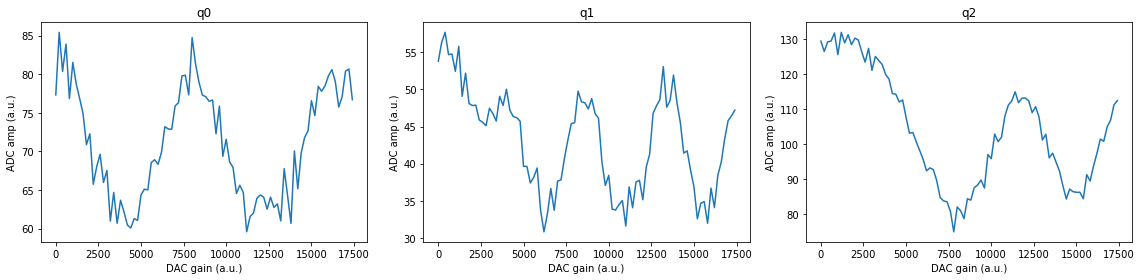

In [514]:

class AmplitudeRabi(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_chs'])):
            
            self.declare_gen(ch=cfg["qubit_chs"][i], nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=cfg["qubit_chs"][i], ro_ch=0) 
             
#             self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)
#             self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="arb", freq=freq, 
#                                     phase=self.deg2reg(90, gen_ch=cfg["qubit_chs"][i]), 
#                                      gain=cfg["qubit_gain"], waveform=f"qubit{i}")
    

            self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="flat_top", freq=freq, phase=0, 
            gain=cfg["qubit_gain"], waveform=f"qubit{i}", length=cfg["qubit_pulse_lengths"][i])
        
    
            self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_chs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
            
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
     
# mixer_freq = res_freqs[0]
# delta_freq = [freq - mixer_freq for freq in res_freqs]

config={
    'qubit_chs': [3, 0, 4],
    'qubit_freqs': config_lenRabi['qubit_freqs'],  
    'qubit_sigmas': config_lenRabi['qubit_sigmas'],
    'qubit_pulse_lengths': config_lenRabi['qubit_pulse_lengths'],
     
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': config_lenRabi['mixer_freq'],
    'delta_freq': config_lenRabi['delta_freq'],  
    
    'gain': config_lenRabi['gain'],
    
    "pulse_length": config_lenRabi['pulse_length'],
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": config_lenRabi['readout_lengths'],
    'adc_trig_offset': config_lenRabi['adc_trig_offset'],
    
    "relax_delay": 10.0, 
    "soft_avgs": 5,
    "reps": 1000   
}
 




gpts = np.arange(0, 17500, 200)
z4 = [[], [], [], []]    


for g in tqdm(gpts):
     
    config['qubit_gain'] = g

    prog = AmplitudeRabi(soccfg, config)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
 
    axs[i].plot(gpts, abs(z4[i]))
    axs[i].set_xlabel('DAC gain (a.u.)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
     
plt.tight_layout() 


# baseline = 200     
# for i in range(3):
#     amp = abs(z4[i])
#     d = baseline - np.max(amp)
#     amp = amp + d    
#     plt.plot(gpts, amp, label=f'q{i}')
# plt.legend()


<ipython-input-204-184a6f64a846>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111, title="Amplitude Rabi Oscillations", xlabel="Pulse length (us)", ylabel="Qubit Population")


[15200, 5200, 8400]

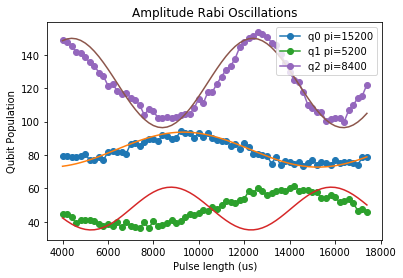

In [204]:
def fitAmpRabi(name, x_pts, amp):  
    def sinfunc(x, *p):
        yscale, freq, phase_deg, y0 = p
        return yscale*np.sin(2*np.pi*freq*x + phase_deg*np.pi/180) + y0

    def fitsin(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*4
        else: fitparams = np.copy(fitparams)
        fourier = np.fft.fft(ydata)
        fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
        fft_phases = np.angle(fourier)
        max_ind = np.argmax(np.abs(fourier[1:])) + 1
        max_freq = np.abs(fft_freqs[max_ind])
        max_phase = fft_phases[max_ind]
        if fitparams[0] is None: fitparams[0]=max(ydata)-min(ydata)
        if fitparams[1] is None: fitparams[1]=max_freq
        if fitparams[2] is None: fitparams[2]=max_phase*180/np.pi
        if fitparams[3] is None: fitparams[3]=np.mean(ydata)
        bounds = (
            [0.5*fitparams[0], 0.2/(max(xdata)-min(xdata)), -360, np.min(ydata)],
            [2*fitparams[0], 5/(max(xdata)-min(xdata)), 360, np.max(ydata)]
            )
        for i, param in enumerate(fitparams):
            if not (bounds[0][i] < param < bounds[1][i]):
                fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
                print(f'Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}')
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            pOpt, pCov = sp.optimize.curve_fit(sinfunc, xdata, ydata, p0=fitparams, bounds=bounds)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov
    ##############################################################################
    def decaysin(x, *p):
        yscale, freq, phase_deg, decay, y0 = p
        return yscale * np.sin(2*np.pi*freq*x + phase_deg*np.pi/180) * np.exp(-x/decay) + y0

    def fitdecaysin(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*5
        else: fitparams = np.copy(fitparams)
        fourier = np.fft.fft(ydata)
        fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
        fft_phases = np.angle(fourier)
        sorted_fourier = np.sort(fourier)
        max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
        if max_ind == 0:
            max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
        max_freq = np.abs(fft_freqs[max_ind])
        max_phase = fft_phases[max_ind]
        if fitparams[0] is None: fitparams[0]=(max(ydata)-min(ydata))/2
        if fitparams[1] is None: fitparams[1]=max_freq
        # if fitparams[2] is None: fitparams[2]=0
        if fitparams[2] is None: fitparams[2]=max_phase*180/np.pi
        if fitparams[3] is None: fitparams[3]=max(xdata) - min(xdata)
        if fitparams[4] is None: fitparams[4]=np.mean(ydata)
        bounds = (
            [0.75*fitparams[0], 0.1/(max(xdata)-min(xdata)), -360, 0.3*(max(xdata)-min(xdata)), np.min(ydata)],
            [1.25*fitparams[0], 30/(max(xdata)-min(xdata)), 360, np.inf, np.max(ydata)]
            )
        for i, param in enumerate(fitparams):
            if not (bounds[0][i] < param < bounds[1][i]):
                fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
                print(f'Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}')
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            pOpt, pCov = sp.optimize.curve_fit(decaysin, xdata, ydata, p0=fitparams, bounds=bounds)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov
 
    pOpt, _= fitsin(x_pts, amp)
    sim = sinfunc(x_pts, *pOpt)
    
    pi_gain = x_pts[np.argmin(sim)]
    
    plt.subplot(111, title="Amplitude Rabi Oscillations", xlabel="Pulse length (us)", ylabel="Qubit Population")
    plt.plot(x_pts, amp, 'o-', label=f"{name} pi={pi_gain}")
    plt.plot(x_pts, sim)
#     plt.axvline(13300,color='r')
#     plt.axvline(6750,color='r')
#     plt.axhline(-4.07465913372093,color='g')
    plt.legend()
    
    return pi_gain

pi_gains = []
for i in range(3):
    pi_gain = fitAmpRabi(f'q{i}', gpts, abs(z4[i]))
    pi_gains.append(pi_gain)

pi_gains    

In [207]:
pi_sigmas = [20]*3
  

In [206]:
pi_gains = [5000, 7500, 8750]

# pi_gains = [9400, 7800, 8000]
# pi_gains = [9600, 9400, 8000]

# pi_sigmas = [10, 16, 4]

In [236]:
pi_gains
pi_sigmas

[20, 20, 20]

In [36]:
 
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)

comment = str(config) #json.dumps(config, indent=4)

filename = 'muxed_Amplitude_Rabi'
data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
database_path = create_labber_datafolder(os.path.join(data_path))
filepath = os.path.join(database_path, filename)

hdf5_generator(
    filepath = filepath,
    x_info = {'name':'pulse length', 'unit':"ns", 'values': gpts},
    z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
    y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
    comment = comment, 
    tag = f'OneTone/pdr'
)

upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

2024-05-27 14:12:03,407 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/05/Data_0527/muxed_Amplitude_Rabi.hdf5 uploaded successfully


# T1

100%|██████████| 75/75 [00:08<00:00,  8.46it/s]


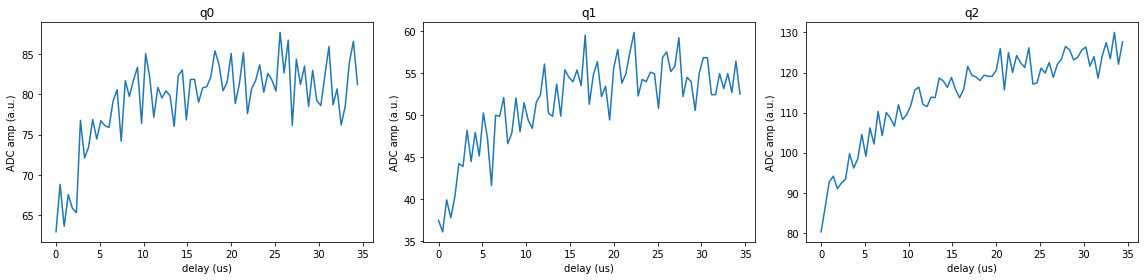

In [588]:

class T1(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_chs'])):
            
            ch=cfg["qubit_chs"][i]
            
            self.declare_gen(ch=cfg["qubit_chs"][i], nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=cfg["qubit_chs"][i], ro_ch=0) 
             
#             self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)
#             self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="arb", freq=freq, 
#                                     phase=self.deg2reg(90, gen_ch=cfg["qubit_chs"][i]), 
#                                      gain=cfg["qubit_gains"][i], waveform=f"qubit{i}")
    
            self.add_gauss(ch=ch, name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.set_pulse_registers(ch=ch, style="flat_top", freq=freq, phase=0, 
                                    gain=cfg["qubit_gains"][i], waveform=f"qubit{i}",
                                     length=cfg["qubit_pulse_lengths"][i])
    
    
    
            self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_chs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
        self.sync_all(self.cfg['delay']) 
        
 
        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       

# config_lenRabi['pi_lens'][1] = 82
# config_lenRabi['pi_lens'][1] = 4

config_t1={
    'qubit_chs': [3, 0, 4], 

    'qubit_freqs': config_lenRabi['qubit_freqs'], 
    'qubit_gains': config_lenRabi['qubit_gains'],
    'qubit_sigmas': config_lenRabi['qubit_sigmas'],
    'qubit_pulse_lengths': config_lenRabi['pi_lens'],
         
    "sgMux_ch": 6,
    'nqz': 2,

    'mixer_freq': config_lenRabi['mixer_freq'],
    'delta_freq': config_lenRabi['delta_freq'],   
     
    'gain': config_lenRabi['gain'],         
    "pulse_length": config_lenRabi['pulse_length'],
    
    'mask': [0, 1, 2], 
    "adc_ch": [0, 1, 2, 3],  
    "readout_lengths": config_lenRabi['readout_lengths'],
    'adc_trig_offset': config_lenRabi['adc_trig_offset'],
        
    "relax_delay": 10.0, 
    "soft_avgs": 3,
    "reps": 1000   
}


  
        
# lpts = np.arange(0, 25000, 250)
lpts = np.arange(0, 15000, 200)

z4 = [[], [], [], []]    

for l in tqdm(lpts):
     
    config_t1['delay'] = l

    prog = T1(soccfg, config_t1)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
 
    axs[i].plot(soc.cycles2us(lpts), abs(z4[i]))
    axs[i].set_xlabel('delay (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
     
plt.tight_layout() 

 


<ipython-input-589-50bb7694b947>:7: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


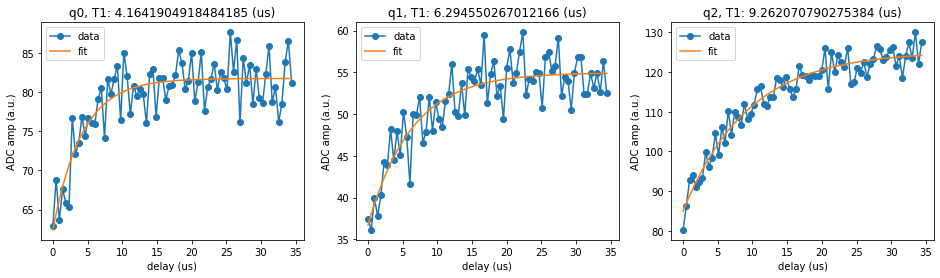

In [589]:
import scipy as sp

def fitT1(ch, ax, lpts, amps):
     
    def expfunc(x, *p):
        y0, yscale, x0, decay = p
        return y0 + yscale*np.exp(-(x-x0)/decay)

    def fitexp(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*4
        else: fitparams = np.copy(fitparams)
        if fitparams[0] is None: fitparams[0] = ydata[-1]
        if fitparams[1] is None: fitparams[1] = ydata[0]-ydata[-1]
        if fitparams[2] is None: fitparams[2] = xdata[0]
        if fitparams[3] is None: fitparams[3] = (xdata[-1]-xdata[0])/5
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            pOpt, pCov = sp.optimize.curve_fit(expfunc, xdata, ydata, p0=fitparams)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov
 
    
    lpts_us = soccfg.cycles2us(np.array(lpts)) # default use tproc facbric clk for conversion.
    
    pOpt, _= fitexp(lpts_us, amps)
    amps_fit = expfunc(lpts_us, *pOpt)
    
    ax.plot(lpts_us, amps, marker='o', label='data')
    ax.plot(lpts_us, amps_fit, label='fit')
     
    t1 = pOpt[3] # us.
    return t1

 


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    
for i in range(3): 
    
    t1 = fitT1(config_lenRabi['qubit_chs'][i], axs[i], lpts, abs(z4[i]))
    
    axs[i].set_xlabel('delay (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}, T1: {t1} (us)')   
    axs[i].legend()    

In [575]:

 
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)

comment =  json.dumps(config_t1, indent=4) + ',\nall current 0 A.'

filename = 'muxed_T1_2'
data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
database_path = create_labber_datafolder(os.path.join(data_path))
filepath = os.path.join(database_path, filename)

hdf5_generator(
    filepath = filepath,
    x_info = {'name':'delay', 'unit':"ns", 'values': soc.cycles2us(lpts)*1e3},
    z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
    y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
    comment = comment, 
    tag = f'OneTone/pdr'
)

upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)



2024-06-15 09:52:47,809 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_T1_2.hdf5 uploaded successfully


# T2E

100%|██████████| 400/400 [03:37<00:00,  1.84it/s]


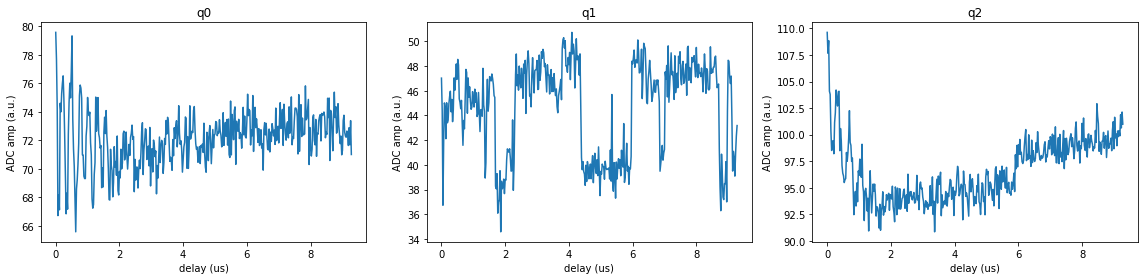

In [661]:

class T2E(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
         
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        
 
        for q in range(len(cfg["adc_ch"])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                 
                
        for i in range(len(cfg['qubit_chs'])):
            
            ch = cfg["qubit_chs"][i]
            
            self.declare_gen(ch=ch, nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=ch, ro_ch=0) 
             
            self.add_gauss(ch=ch, name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.default_pulse_registers(ch=ch, style="flat_top", freq=freq, 
                        phase=0, waveform=f"qubit{i}", gain=cfg["qubit_gains"][i])    
 
            
        self.sync_all(self.us2cycles(1))
                
 
    
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_chs'])): 
            self.setup_and_pulse(ch=cfg["qubit_chs"][i], length=cfg["pi2_lens"][i])

        self.sync_all(cfg['delay'])

        for i in range(len(cfg['qubit_chs'])): 
            self.setup_and_pulse(ch=cfg["qubit_chs"][i], length=cfg["pi_lens"][i])
         
        self.sync_all(cfg['delay'])      
         
        for i in range(len(cfg['qubit_chs'])): 
            self.setup_and_pulse(ch=cfg["qubit_chs"][i], length=cfg["pi2_lens"][i])
              
       
        self.sync_all()
 
        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
 
     
 
config_t2e={
    'qubit_chs': [3, 0, 4],
 
    'qubit_freqs': config_lenRabi['qubit_freqs'], 
    'qubit_gains': config_lenRabi['qubit_gains'],
    'qubit_sigmas': config_lenRabi['qubit_sigmas'],
    'pi_lens': config_lenRabi['pi_lens'],
    'pi2_lens': config_lenRabi['pi2_lens'],
        
    "sgMux_ch": 6,
    'nqz': 2, 
    
    'mixer_freq': config_lenRabi['mixer_freq'],
    'delta_freq': config_lenRabi['delta_freq'],    
    'gain': config_lenRabi['gain'],         
    "pulse_length": config_lenRabi['pulse_length'],
    
    
    'mask': [0, 1, 2], 
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": config_lenRabi['readout_lengths'],
    'adc_trig_offset': config_lenRabi['adc_trig_offset'],
        
    "relax_delay": 10, 
    "soft_avgs": 20,
    "reps": 1000
}


  
  
         
dpts = np.arange(0, 4000, 10)

z4 = [[], [], [], []]    

for d in tqdm(dpts):
     
    config_t2e['delay'] = d

    t2e = T2E(soccfg, config_t2e)
    avgi, avgq = t2e.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
 
    axs[i].plot(soc.cycles2us(dpts), abs(z4[i]))
    axs[i].set_xlabel('delay (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
     
plt.tight_layout() 

 
        

In [ ]:

# class T2E(RAveragerProgram):
#     def initialize(self):
#         cfg=self.cfg        
        
#         self.q_rps=[self.ch_page(ch) for ch in cfg["qubit_chs"]]
#         self.r_wait = 3
#         for q_rp in self.q_rps: 
#             self.regwi(q_rp, self.r_wait, cfg["start"])
        
        
#         self.declare_gen( # res.
#                          ch = cfg["sgMux_ch"],  
#                          nqz = cfg['nqz'],  
#                          mixer_freq = cfg['mixer_freq'], 
#                          mux_freqs = cfg['delta_freq'], 
#                          mux_gains = cfg['gain'], 
#                          ro_ch = 0)

#         self.set_pulse_registers(ch = cfg["sgMux_ch"], 
#                                  style = 'const', 
#                                  length = cfg["pulse_length"], 
#                                  mask = cfg['mask'])        

         
        
#         for q in range(len(cfg["adc_ch"])):
#             self.declare_readout(ch = cfg["adc_ch"][q], 
#                                  length = cfg["readout_lengths"][q], 
#                                  freq = cfg['delta_freq'][q], 
#                                  gen_ch = cfg["sgMux_ch"])
                
                 
                
#         for i in range(len(cfg['qubit_chs'])):
            
#             ch = cfg["qubit_chs"][i]
            
#             self.declare_gen(ch=ch, nqz=2) #Qubit 
#             freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=ch, ro_ch=0) 
             
#             self.add_gauss(ch=ch, name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)        
        
#             self.default_pulse_registers(ch=ch, style="arb", freq=freq, 
#                         phase=0, waveform=f"qubit{i}")
        
            
#         self.sync_all(self.us2cycles(1))
                
 
    
#     def body(self):
        
#         cfg=self.cfg        
        
# #         for i in range(len(cfg['qubit_chs'])): 
# #             self.setup_and_pulse(ch=cfg["qubit_chs"][i], gain=cfg["qubit_gains"][i]//2)

#         self.setup_and_pulse(ch=cfg["qubit_chs"][0], gain=cfg["qubit_gains"][0]//2)
#         self.sync(self.q_rps[0], self.r_wait)
        
# #         for i in range(len(cfg['qubit_chs'])): 
# #             self.setup_and_pulse(ch=cfg["qubit_chs"][i], gain=cfg["qubit_gains"][i])
        
#         self.setup_and_pulse(ch=cfg["qubit_chs"][0], gain=cfg["qubit_gains"][0])
#         self.sync(self.q_rps[0], self.r_wait)        
         
# #         for i in range(len(cfg['qubit_chs'])): 
# #             self.setup_and_pulse(ch=cfg["qubit_chs"][i], gain=cfg["qubit_gains"][i]//2)
              
#         self.setup_and_pulse(ch=cfg["qubit_chs"][0], gain=cfg["qubit_gains"][0]//2)
        
#         self.sync_all(self.us2cycles(0.05))
 
#         self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
#         self.pulse(ch=self.cfg['sgMux_ch'])
#         self.wait_all() 
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
 
    
#     def update(self):
#         for q_rp in self.q_rps: 
#             self.mathi(q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"])
        

 
# config={
#     'qubit_chs': [3, 0, 4],
 
#     'qubit_freqs': config_lenRabi['qubit_freqs'], 
#     'qubit_gains': config_lenRabi['qubit_gains'],
#     'qubit_sigmas': config_lenRabi['qubit_sigmas'],
#     'pi_lens': config_lenRabi['pi_lens'],
#     'pi2_lens': config_lenRabi['pi2_lens'],
        
#     "sgMux_ch": 6,
#     'nqz': 2, 
    
#     'mixer_freq': config_lenRabi['mixer_freq'],
#     'delta_freq': config_lenRabi['delta_freq'],    
#     'gain': config_lenRabi['gain'],         
#     "pulse_length": config_lenRabi['pulse_length'],
    
    
#     'mask': [0, 1, 2], 
#     "adc_ch": [0, 1, 2, 3], 
#     "readout_lengths": config_lenRabi['readout_lengths'],
#     'adc_trig_offset': config_lenRabi['adc_trig_offset'],
        
#     "relax_delay": 50, 
#     "soft_avgs": 1,
#     "reps": 1000
# }


 

# expt_cfg={"start":0, "step":40, "expts":100, "rounds": 2000}
# config={**config,**expt_cfg} #combine configs


# t2e=T2E(soccfg, config)
# x_pts, avgi, avgq= t2e.acquire(soc, progress=True)


# z4 = []
# for i in range(3):
#     z4.append(avgi[i][0] + 1j*avgq[i][0])
# z4 = np.array(z4)


# # for i in range(3):
# #     plt.plot(soc.cycles2us(x_pts), abs(z4[i]), label=f'q{i}')
# # plt.legend()

# i=0
# plt.plot(soc.cycles2us(x_pts), abs(z4[i]), label=f'q{i}')
        
        

# T2R

100%|██████████| 125/125 [00:36<00:00,  3.44it/s]


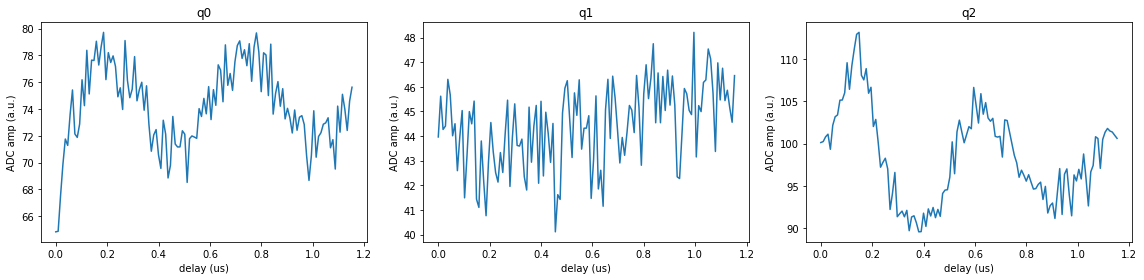

In [689]:
 

class T2R(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
  
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_chs'])):
            
            ch = cfg["qubit_chs"][i]
            
            self.declare_gen(ch=ch, nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=ch, ro_ch=0) 
             
#             self.add_gauss(ch=ch, name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)
             
#             self.set_pulse_registers(ch=ch, style="arb", freq=freq, 
#                                     phase=0, 
#                                      gain=cfg["qubit_gains"][i], waveform=f"qubit{i}")
    
  
            self.add_gauss(ch=ch, name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
            self.set_pulse_registers(ch=ch, style="flat_top", freq=freq, phase=0, 
            gain=cfg["qubit_gains"][i], waveform=f"qubit{i}", length=cfg["qubit_pulse_lengths"][i])
    
    
        self.sync_all(self.us2cycles(1))
                
 
    
    def body(self):
        
        cfg=self.cfg        
        
        for i in range(len(cfg['qubit_chs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
        self.sync_all(cfg['delay'])
                
        for i in range(len(cfg['qubit_chs'])):
            self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse

#         self.sync_all(self.us2cycles(0.05))
        self.sync_all()
 
        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
    
 

# config_lenRabi['pi2_lens'][1] = 63
    
config_t2r={
    'qubit_chs': [3, 0, 4],
      
#     'qubit_freqs': config_lenRabi['qubit_freqs'], 
#     'qubit_freqs': [3903.5, 4302.5, 3313.5], 
    'qubit_freqs': [3903.5, 4302.5, 3313.5], 
    
#     'qubit_gains': config_lenRabi['qubit_gains'],
#     'qubit_gains': [4000, 6000, 8000],
    'qubit_gains': [4000, 6000, 8000],
        
    'qubit_sigmas': config_lenRabi['qubit_sigmas'],
    'qubit_pulse_lengths': config_lenRabi['pi2_lens'],
        
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': config_lenRabi['mixer_freq'],
    'delta_freq': config_lenRabi['delta_freq'],   
    
#     'gain': config_lenRabi['gain'], 
    'gain': [0.027, 0.027, 0.027, 0.067],     
        
    "pulse_length": config_lenRabi['pulse_length'],
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": config_lenRabi['readout_lengths'],
    'adc_trig_offset': config_lenRabi['adc_trig_offset'],
    
    "relax_delay": 20.0, 
    "soft_avgs": 10,
    "reps": 1000
}

z4 = [[], [], [], []]    
dpts = np.arange(0, 500, 4)

for d in tqdm(dpts):
    config_t2r['delay'] = d
    t2r=T2R(soccfg, config_t2r)
    avgi, avgq = t2r.acquire(soc, load_pulses=True) 

    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])

for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(len(fpts4)):
 
    axs[i].plot(soc.cycles2us(dpts), abs(z4[i]))
    axs[i].set_xlabel('delay (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{i}')    
     
plt.tight_layout() 

                

In [595]:

def fit_t2():
    import scipy as sp
    def decaysin(x, *p):
        yscale, freq, phase_deg, decay, y0 = p
        return yscale * np.sin(2*np.pi*freq*x + phase_deg*np.pi/180) * np.exp(-x/decay) + y0

    def fitdecaysin(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*5
        else: fitparams = np.copy(fitparams)
        fourier = np.fft.fft(ydata)
        fft_freqs = np.fft.fftfreq(len(ydata), d=xdata[1]-xdata[0])
        fft_phases = np.angle(fourier)
        sorted_fourier = np.sort(fourier)
        max_ind = np.argwhere(fourier == sorted_fourier[-1])[0][0]
        if max_ind == 0:
            max_ind = np.argwhere(fourier == sorted_fourier[-2])[0][0]
        max_freq = np.abs(fft_freqs[max_ind])
        max_phase = fft_phases[max_ind]
        if fitparams[0] is None: fitparams[0]=(max(ydata)-min(ydata))/2
        if fitparams[1] is None: fitparams[1]=max_freq
        # if fitparams[2] is None: fitparams[2]=0
        if fitparams[2] is None: fitparams[2]=max_phase*180/np.pi
        if fitparams[3] is None: fitparams[3]=max(xdata) - min(xdata)
        if fitparams[4] is None: fitparams[4]=np.mean(ydata)
        bounds = (
            [0.75*fitparams[0], 0.1/(max(xdata)-min(xdata)), -360, 0.3*(max(xdata)-min(xdata)), np.min(ydata)],
            [1.25*fitparams[0], 10/(max(xdata)-min(xdata)), 360, np.inf, np.max(ydata)]
            )
        for i, param in enumerate(fitparams):
            if not (bounds[0][i] < param < bounds[1][i]):
                fitparams[i] = np.mean((bounds[0][i], bounds[1][i]))
                print(f'Attempted to init fitparam {i} to {param}, which is out of bounds {bounds[0][i]} to {bounds[1][i]}. Instead init to {fitparams[i]}')
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            pOpt, pCov = sp.optimize.curve_fit(decaysin, xdata, ydata, p0=fitparams, bounds=bounds)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov


    ##############################################################################################################
    plt.subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time ($\mu$s)", ylabel="Qubit Population")
    pOpt,_= fitdecaysin(soccfg.cycles2us(x_pts), np.abs(avgi[0][0]+1j*avgq[0][0]))
    sim = decaysin(soccfg.cycles2us(x_pts), *pOpt)
    plt.plot(soccfg.cycles2us(x_pts), np.abs(avgi[0][0]+1j*avgq[0][0]),'o-')
    plt.plot(soccfg.cycles2us(x_pts), sim, label = f'detune ={pOpt[1]:.3f}MHz, \nT2R = {pOpt[3]:.2f}us,')
    plt.legend()

    detune = pOpt[1]    

[0.027, 0.027, 0.027, 0.067]

In [547]:
abs(z4[i]).shape

()

  0%|          | 0/2000 [00:00<?, ?it/s]

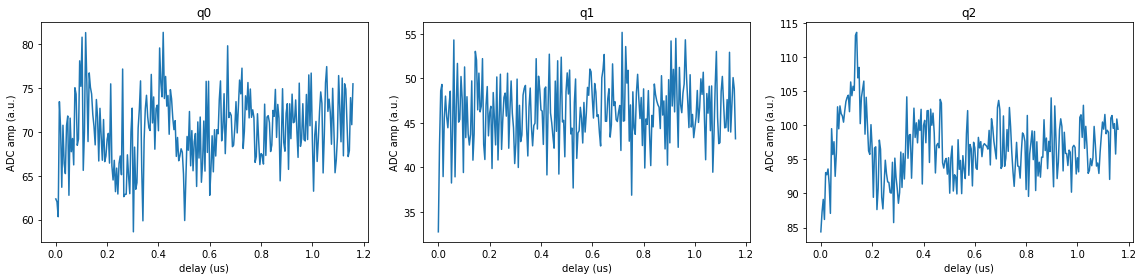

In [532]:
 

# class T2R(RAveragerProgram):
#     def initialize(self):
#         cfg=self.cfg        
        
#         self.q_rps=[self.ch_page(ch) for ch in cfg["qubit_chs"]]
#         self.r_wait = 3
#         for q_rp in self.q_rps: 
#             self.regwi(q_rp, self.r_wait, cfg["start"])
        
        
#         self.declare_gen( # res.
#                          ch = cfg["sgMux_ch"],  
#                          nqz = cfg['nqz'],  
#                          mixer_freq = cfg['mixer_freq'], 
#                          mux_freqs = cfg['delta_freq'], 
#                          mux_gains = cfg['gain'], 
#                          ro_ch = 0)

#         self.set_pulse_registers(ch = cfg["sgMux_ch"], 
#                                  style = 'const', 
#                                  length = cfg["pulse_length"], 
#                                  mask = cfg['mask'])        

#         for q in range(len(cfg['delta_freq'])):
#             self.declare_readout(ch = cfg["adc_ch"][q], 
#                                  length = cfg["readout_lengths"][q], 
#                                  freq = cfg['delta_freq'][q], 
#                                  gen_ch = cfg["sgMux_ch"])
                
#         for i in range(len(cfg['qubit_chs'])):
            
#             ch = cfg["qubit_chs"][i]
            
#             self.declare_gen(ch=ch, nqz=2) #Qubit 
#             freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=ch, ro_ch=0) 
             
# #             self.add_gauss(ch=ch, name=f"qubit{i}", 
# #                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)
             
# #             self.set_pulse_registers(ch=ch, style="arb", freq=freq, 
# #                                     phase=0, 
# #                                      gain=cfg["qubit_gains"][i], waveform=f"qubit{i}")
    
  
#             self.add_gauss(ch=ch, name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
#             self.set_pulse_registers(ch=ch, style="flat_top", freq=freq, phase=0, 
#             gain=cfg["qubit_gains"][i], waveform=f"qubit{i}", length=cfg["qubit_pulse_lengths"][i])
    
    
#         self.sync_all(self.us2cycles(1))
                
 
    
#     def body(self):
        
#         cfg=self.cfg        
        
#         for i in range(len(cfg['qubit_chs'])):
#             self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
#         self.sync(self.q_rps[0], self.r_wait)
                
#         for i in range(len(cfg['qubit_chs'])):
#             self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse

#         self.sync_all(self.us2cycles(0.05))
 
#         self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
#         self.pulse(ch=self.cfg['sgMux_ch'])
#         self.wait_all() 
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
    
#     def update(self):
#         for q_rp in self.q_rps: 
#             self.mathi(q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"])
        
         

    
    
# config_t2r={
#     'qubit_chs': [3, 0, 4],
      
#     'qubit_freqs': config_lenRabi['qubit_freqs'], 
#     'qubit_gains': config_lenRabi['qubit_gains'],
#     'qubit_sigmas': config_lenRabi['qubit_sigmas'],
#     'qubit_pulse_lengths': config_lenRabi['pi2_lens'],
        
#     "sgMux_ch": 6,
#     'nqz': 2,
#     'mixer_freq': config_lenRabi['mixer_freq'],
#     'delta_freq': config_lenRabi['delta_freq'],   
    
#     'gain': config_lenRabi['gain'], 
        
#     "pulse_length": config_lenRabi['pulse_length'],
#     'mask': [0, 1, 2],
    
#     "adc_ch": [0, 1, 2, 3], 
#     "readout_lengths": config_lenRabi['readout_lengths'],
#     'adc_trig_offset': config_lenRabi['adc_trig_offset'],
    
#     "relax_delay": 10.0, 
#     "soft_avgs": 1,
#     "reps": 1  
# }

# expt_cfg={"start":0, "step":2, "expts":250, "rounds": 2000
#        }
# config_t2r={**config_t2r,**expt_cfg} #combine configs


# t2r=T2R(soccfg, config_t2r)
# x_pts, avgi, avgq= t2r.acquire(soc, progress=True)


# z4 = []
# for i in range(4):
#     z4.append(avgi[i][0] + 1j*avgq[i][0])
# z4 = np.array(z4)



# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
# for i in range(len(fpts4)):
 
#     axs[i].plot(soc.cycles2us(x_pts), abs(z4[i]))
#     axs[i].set_xlabel('delay (us)')
#     axs[i].set_ylabel('ADC amp (a.u.)') 
#     axs[i].set_title(f'q{i}')    
     
# plt.tight_layout() 

                

<ipython-input-333-84d6991fd41b>:7: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


q0 detune: -10.840560158242216
q1 detune: 3.899452408115375
q2 detune: 2.9009964708312674


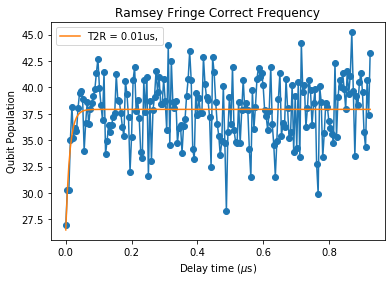

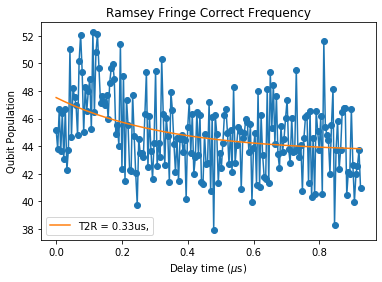

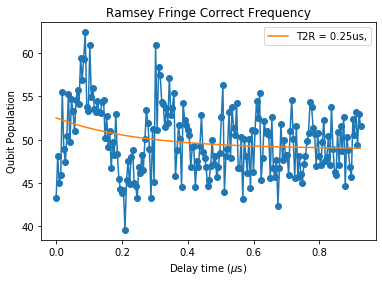

In [333]:

def fitT2R(name, x_pts, amp):
    
    import scipy as sp
    
    def expfunc(x, *p):
        y0, yscale, x0, decay = p
        return y0 + yscale*np.exp(-(x-x0)/decay)

    def fitexp(xdata, ydata, fitparams=None):
        if fitparams is None: fitparams = [None]*4
        else: fitparams = np.copy(fitparams)
        if fitparams[0] is None: fitparams[0] = ydata[-1]
        if fitparams[1] is None: fitparams[1] = ydata[0]-ydata[-1]
        if fitparams[2] is None: fitparams[2] = xdata[0]
        if fitparams[3] is None: fitparams[3] = (xdata[-1]-xdata[0])/5
        pOpt = fitparams
        pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
        try:
            pOpt, pCov = sp.optimize.curve_fit(expfunc, xdata, ydata, p0=fitparams)
            # return pOpt, pCov
        except RuntimeError: 
            print('Warning: fit failed!')
            # return 0, 0
        return pOpt, pCov

    pOpt, _= fitexp(soc.cycles2us(x_pts), amp)
    sim = expfunc(soc.cycles2us(x_pts), *pOpt)
    plt.subplot(111, title="Ramsey Fringe Correct Frequency", xlabel="Delay time ($\mu$s)", ylabel="Qubit Population")
    plt.plot(soccfg.cycles2us(x_pts), amp,'o-')
    plt.plot(soccfg.cycles2us(x_pts), sim, label = f'T2R = {pOpt[3]:.2f}us,')
    plt.legend()
    print(f'{name} detune: {pOpt[1]}')

# u=5  
for i in range(3):
    plt.figure()
    fitT2R(f'q{i}', x_pts, abs(z4[i]))
    
#     fitT2R(x_pts, numpy.imag(z4[i]))

In [158]:

# class T2R(AveragerProgram):
#     def initialize(self):
#         cfg=self.cfg        
        
#         self.declare_gen( # res.
#                          ch = cfg["sgMux_ch"],  
#                          nqz = cfg['nqz'],  
#                          mixer_freq = cfg['mixer_freq'], 
#                          mux_freqs = cfg['delta_freq'], 
#                          mux_gains = cfg['gain'], 
#                          ro_ch = 0)

#         self.set_pulse_registers(ch = cfg["sgMux_ch"], 
#                                  style = 'const', 
#                                  length = cfg["pulse_length"], 
#                                  mask = cfg['mask'])        

#         for q in range(len(cfg['delta_freq'])):
#             self.declare_readout(ch = cfg["adc_ch"][q], 
#                                  length = cfg["readout_lengths"][q], 
#                                  freq = cfg['delta_freq'][q], 
#                                  gen_ch = cfg["sgMux_ch"])
                
#         for i in range(len(cfg['qubit_chs'])):
            
#             ch = cfg["qubit_chs"][i]
            
#             self.declare_gen(ch=ch, nqz=2) #Qubit 
#             freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=ch, ro_ch=0) 
             
#             self.add_gauss(ch=ch, name=f"qubit{i}", 
#                            sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*4)
             
#             self.set_pulse_registers(ch=ch, style="arb", freq=freq, 
#                                     phase=0, 
#                                      gain=cfg["qubit_gains"][i], waveform=f"qubit{i}")
    
#             self.sync_all(self.us2cycles(1))
                
 
# #     def body(self):
        
# #         cfg=self.cfg        
                
# #         self.pulse(ch=self.cfg["qubit_chs"][1])  #play probe pulse
        
# #         self.sync_all(self.cfg['delay'])  
                
# #         self.pulse(ch=self.cfg["qubit_chs"][1])  #play probe pulse

# #         self.sync_all(self.us2cycles(0.05))
 
# #         self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
# #         self.pulse(ch=self.cfg['sgMux_ch'])
# #         self.wait_all() 
# #         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
#     def body(self):
        
#         cfg=self.cfg        
        
#         for i in range(len(cfg['qubit_chs'])):
#             self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
#         self.sync_all(self.cfg['delay'])  
        
#         for i in range(len(cfg['qubit_chs'])):
#             self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse

#         self.sync_all(self.us2cycles(0.05))
 
#         self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
#         self.pulse(ch=self.cfg['sgMux_ch'])
#         self.wait_all() 
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
    
# res_freqs = [5715.75, 6005.5, 5828.5, 5200] # 1, 2, 3, 5.

# qubit_freqs = [3880, 4249, 3335]

# mixer_freq = res_freqs[0]
# delta_freq = [freq - mixer_freq for freq in res_freqs]



# pi_gains = [9400, 7800, 8000]
# pi_sigmas = [10, 16, 4]

# config={
#     'qubit_chs': [3, 0, 4],
#     'qubit_freqs': qubit_freqs, 
#     'qubit_pulse_length': [soc.us2cycles(5)]*len(qubit_freqs),
#     'qubit_gains': np.array(pi_gains)//2,
# #     'qubit_sigmas': [soccfg.us2cycles(0.02)]*len(qubit_freqs),
#     'qubit_sigmas': pi_sigmas,
    
#     "sgMux_ch": 6,
#     'nqz': 2,
#     'mixer_freq': mixer_freq,
#     'delta_freq': delta_freq,    
#     'gain': [0.067]*4,
# #     'gain': [0.2]*4,
#     "pulse_length": soc.us2cycles(2),
#     'mask': [0, 1, 2, 3],
    
#     "adc_ch": [0, 1, 2, 3], 
#     "readout_lengths": [soc.us2cycles(2)]*4,
#     'adc_trig_offset': soc.us2cycles(0.45),
    
#     "relax_delay": 10.0, 
#     "soft_avgs": 2,
#     "reps": 1000   
# }


# lpts = np.arange(0, 2000, 5)
# z4 = [[], [], [], []]    

# for l in tqdm(lpts):
     
#     config['delay'] = l

#     prog = T2R(soccfg, config)
#     avgi, avgq = prog.acquire(soc, load_pulses=True)
    
#     for i in range(4):
#         z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
# for i in range(4):
#     z4[i] = np.array(z4[i])    
# z4 = np.array(z4)   

# for i in range(3):
#     plt.plot(soc.cycles2us(lpts), abs(z4[i]))




 24%|██▎       | 94/400 [00:04<00:15, 19.46it/s]


KeyboardInterrupt: 

# Crosstalk-lenRabi

100%|██████████| 200/200 [01:09<00:00,  2.88it/s]


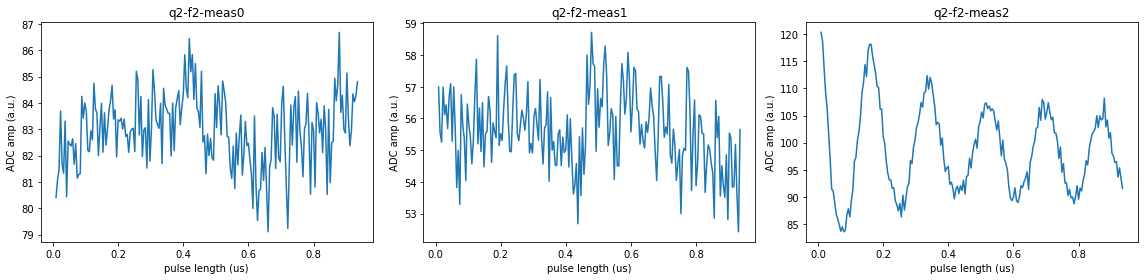

In [687]:
q = [0, 1, 2][2]
f = [0, 1, 2][2]

class CrosstalkLenRabi(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for i in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][i], 
                                 length = cfg["readout_lengths"][i], 
                                 freq = cfg['delta_freq'][i], 
                                 gen_ch = cfg["sgMux_ch"])
                


        self.declare_gen(ch=cfg["qubit_chs"][q], nqz=2) #Qubit 
        freq=self.freq2reg(cfg["qubit_freqs"][f], gen_ch=cfg["qubit_chs"][q], ro_ch=0)  

        self.add_gauss(ch=cfg["qubit_chs"][q], name=f"qubit{q}", 
                       sigma=cfg["qubit_sigmas"][f], length=cfg["qubit_sigmas"][f]*4)
        self.set_pulse_registers(ch=cfg["qubit_chs"][q], style="flat_top", freq=freq, 
                                 phase=0, gain=cfg["qubit_gains"][f], 
                                 waveform=f"qubit{q}", length=cfg["qubit_pulse_length"])

    
        self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
        self.pulse(ch=self.cfg["qubit_chs"][q])
        
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
config_crosstalk_lenRabi = {
    'qubit_chs': [3, 0, 4],
    'qubit_freqs': config_twotone['qubit_freqs'],   
    'qubit_gains': [4000, 6000, 8000], 
    'qubit_sigmas': [2, 2, 2],
        
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': config_twotone['mixer_freq'],
    'delta_freq': config_twotone['delta_freq'],    
  
    'gain': [0.027, 0.027, 0.027, 0.067],
    
    "pulse_length": config_twotone['pulse_length'],
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths":  config_twotone['readout_lengths'],
    'adc_trig_offset': config_twotone['adc_trig_offset'],
    
    "relax_delay": 10.0, 
    "soft_avgs": 20,
    "reps": 1000   
}


lpts = np.arange(4, 404, 2)
z4 = [[], [], [], []]    

for l in tqdm(lpts):
     
    config_crosstalk_lenRabi['qubit_pulse_length'] = int(l)

    prog = CrosstalkLenRabi(soccfg, config_crosstalk_lenRabi)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i in range(3):
 
    axs[i].plot(soc.cycles2us(lpts), abs(z4[i]))
    axs[i].set_xlabel('pulse length (us)')
    axs[i].set_ylabel('ADC amp (a.u.)') 
    axs[i].set_title(f'q{q}-f{f}-meas{i}')    
     
plt.tight_layout() 



In [688]:
 
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)


comment = json.dumps(config_crosstalk_lenRabi, indent=4) + ', \nall current 0 A'

filename = f'muxed_crosstalk_lenRabi_q{q}-f{f}'
data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
database_path = create_labber_datafolder(os.path.join(data_path))
filepath = os.path.join(database_path, filename)

hdf5_generator(
    filepath = filepath,
    x_info = {'name':'pulse length', 'unit':"ns", 'values':soccfg.cycles2us(lpts)*1e3},
    z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
    y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
    comment = comment, 
    tag = f'OneTone/pdr'
)
upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

2024-06-15 12:56:24,564 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/06/Data_0615/muxed_crosstalk_lenRabi_q2-f2.hdf5 uploaded successfully


# Crosstalk-ampRabi

In [369]:



class AmplitudeRabi(AveragerProgram):
    def initialize(self):
        cfg=self.cfg        
        
        self.declare_gen( # res.
                         ch = cfg["sgMux_ch"],  
                         nqz = cfg['nqz'],  
                         mixer_freq = cfg['mixer_freq'], 
                         mux_freqs = cfg['delta_freq'], 
                         mux_gains = cfg['gain'], 
                         ro_ch = 0)

        self.set_pulse_registers(ch = cfg["sgMux_ch"], 
                                 style = 'const', 
                                 length = cfg["pulse_length"], 
                                 mask = cfg['mask'])        

        for q in range(len(cfg['delta_freq'])):
            self.declare_readout(ch = cfg["adc_ch"][q], 
                                 length = cfg["readout_lengths"][q], 
                                 freq = cfg['delta_freq'][q], 
                                 gen_ch = cfg["sgMux_ch"])
                
        for i in range(len(cfg['qubit_chs'])):
            
            self.declare_gen(ch=cfg["qubit_chs"][i], nqz=2) #Qubit 
            freq=self.freq2reg(cfg["qubit_freqs"][i], gen_ch=cfg["qubit_chs"][i], ro_ch=0) 
             
            self.add_gauss(ch=cfg["qubit_chs"][i], name=f"qubit{i}", 
                           sigma=cfg["qubit_sigmas"][i], length=cfg["qubit_sigmas"][i]*5)
            self.set_pulse_registers(ch=cfg["qubit_chs"][i], style="arb", freq=freq, 
                                    phase=self.deg2reg(90, gen_ch=cfg["qubit_chs"][i]), 
                                     gain=cfg["qubit_gain"], waveform=f"qubit{i}")
    
    
            self.sync_all(self.us2cycles(1))
                
  
    def body(self):
        
        cfg=self.cfg        
        
#         for i in range(len(cfg['qubit_chs'])):
#             self.pulse(ch=self.cfg["qubit_chs"][i])  #play probe pulse
        
        self.pulse(ch=self.cfg["qubit_chs"][2])
        
        self.sync_all() # align channels and wait 50ns

        self.trigger(adcs=self.cfg["adc_ch"], adc_trig_offset=self.cfg["adc_trig_offset"])         
        self.pulse(ch=self.cfg['sgMux_ch'])
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
       
    
    
# res_freqs = [5715.75, 6005.5, 5828.5, 5200] # 1, 2, 3, 5.

# qubit_freqs = [3880, 4249, 3335]
# qubit_freqs = [3878.0, 4247.5, 3334.5]



mixer_freq = res_freqs[0]
delta_freq = [freq - mixer_freq for freq in res_freqs]

config={
    'qubit_chs': [3, 0, 4],
    'qubit_freqs': qubit_freqs, 
#     'qubit_gains': [2000, 2000, 500],
#     'qubit_sigmas': [soccfg.us2cycles(0.02)]*len(qubit_freqs),
    'qubit_sigmas': [10, 14, 4] ,
    
    "sgMux_ch": 6,
    'nqz': 2,
    'mixer_freq': mixer_freq,
    'delta_freq': delta_freq,    
#     'gain': [0.067]*4,
    'gain': [0.027]*4,
    
    "pulse_length": soc.us2cycles(2),
    'mask': [0, 1, 2],
    
    "adc_ch": [0, 1, 2, 3], 
    "readout_lengths": [soc.us2cycles(2)]*4,
    'adc_trig_offset': soc.us2cycles(0.45),
    
    "relax_delay": 10.0, 
    "soft_avgs": 15,
    "reps": 1000   
}


gpts = np.arange(0, 25000, 200)
z4 = [[], [], [], []]    

for g in tqdm(gpts):
     
    config['qubit_gain'] = g

    prog = AmplitudeRabi(soccfg, config)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    
    for i in range(4):
        z4[i].append(avgi[i][0] + 1j * avgq[i][0])
       
for i in range(4):
    z4[i] = np.array(z4[i])    
z4 = np.array(z4)   

for i in range(3):
    plt.plot(gpts, abs(z4[i]), label=f'q{i}')
plt.legend()






  0%|          | 0/125 [00:00<?, ?it/s]


KeyError: 3

In [360]:
 
hostip = '192.168.10.39' # cmd-> ipconfig -> ipv4 #controling computer
client = Labber.connectToServer(hostip, timeout=86400)

comment = str(config) #json.dumps(config, indent=4)

filename = 'muxed_crosstalk-q3'
data_path = "/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database"
database_path = create_labber_datafolder(os.path.join(data_path))
filepath = os.path.join(database_path, filename)

hdf5_generator(
    filepath = filepath,
    x_info = {'name':'gain', 'unit':"a.u.", 'values': gpts},
    z_info = {'name': 'Signal','unit': 'a.u.','values': z4},
    y_info = {'name': 'qubits', 'unit': '','values': [1,2,3,4]},
    comment = comment, 
    tag = f'OneTone/pdr'
)

upload_file2server(filepath=filepath+'.hdf5', server_ip='192.168.10.39', port=5000)

2024-05-30 07:05:35,117 - SR_Network:BlockingClient - Error: Connection refused


/home/xilinx/jupyter_notebooks/nthu/sinica-5q/Jay/Database/2024/05/Data_0530/muxed_crosstalk-q3.hdf5 uploaded successfully
